# Convnet의 학습 시각화하기
convnet의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화할 수 있다!

## Convnet 시각화 기법 개요
1. Convnet **중간 층의 출력**을 시각화
    * 연속된 컨브넷 층이 입력을 어떻게 변형시킬까?
    * 개별적인 컨브넷 필터의 의미 파악하기
    

2. Convnet **필터** 시각화
    * 컨브넷 필터가 찾으려는 시각적인 패턴와 개념을 이해하기
    

3. 클래스 활성화에 대한 **heatmap**을 이미지에 시각화
    * 이미지의 어떤 부분이 주어진 클래스에 속하는 데 기여했을까?
    * 이미지에서 객체 위치를 추정(localization)하기
---

## 1. 중간 층의 활성화 시각화하기
어떤 입력이 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성 맵 그리기\
네트워크에 의해 학습된 필터들이 **어떻게 입력을 분해하는지 보여줌**

### pretrained_convnet에서 저장한 모델 load

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Metal device set to: Apple M1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoo

2022-03-23 01:24:43.228628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-23 01:24:43.228865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 개별 이미지 전처리
네트워크를 훈련할 때 사용했던 이미지에 포함되지 않은 고양이 사진 하나를 입력 이미지로 선택하기:

In [2]:

img_path = '../datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용
img_tensor /= 255.

# 이미지 텐서 크기: (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


테스트 사진 출력:

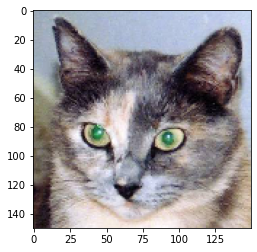

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()